# OVe3D create data

## Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.signal import convolve
from pylops.utils.wavelets import ricker
from pylops.basicoperators import FirstDerivative

from mcslopes.preprocessing import gradient_data3d
from mcslopes.plotting import plotting_style, explode_volume

plotting_style()

## Parameters

In [2]:
# data
dt = 0.004 # time sampling (in s)
dy, dx = 20, 20 # spatial sampling (in m)
ny, nx, nt = 90, 177, 801 # data size in samples
ys, xs = 46 * dy, 93 * dx # Source location

# pre-processing
fwav = 35. # frequency of ricker wavelet to apply to data (in Hz)
nfft_t, nfft_y, nfft_x = 2**10, 2**8, 2**8 # lenght of frequency and wavenumber axis (used to compute gradients and perform FK transforms during data reconstruction)
density = 1000. # medium density at receivers

# subsampling
nsub = 5

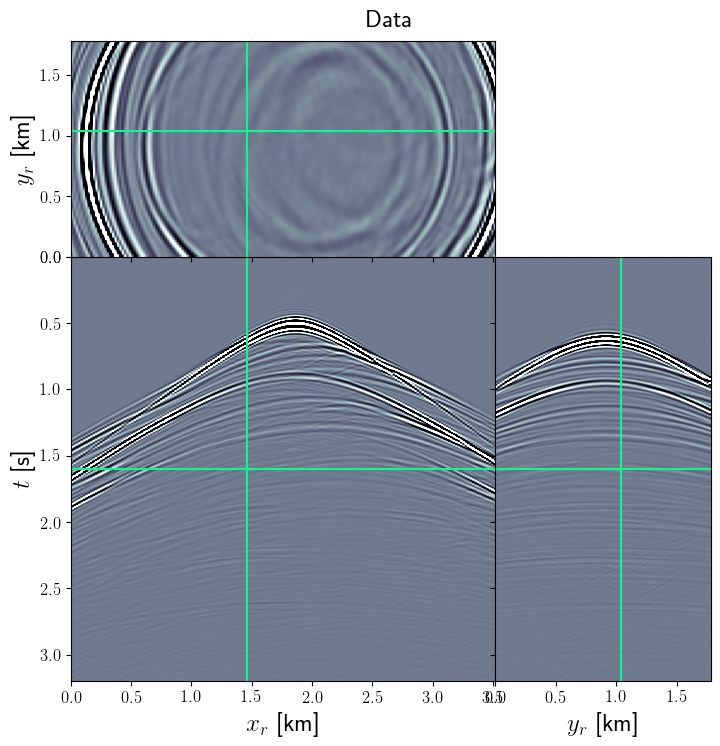

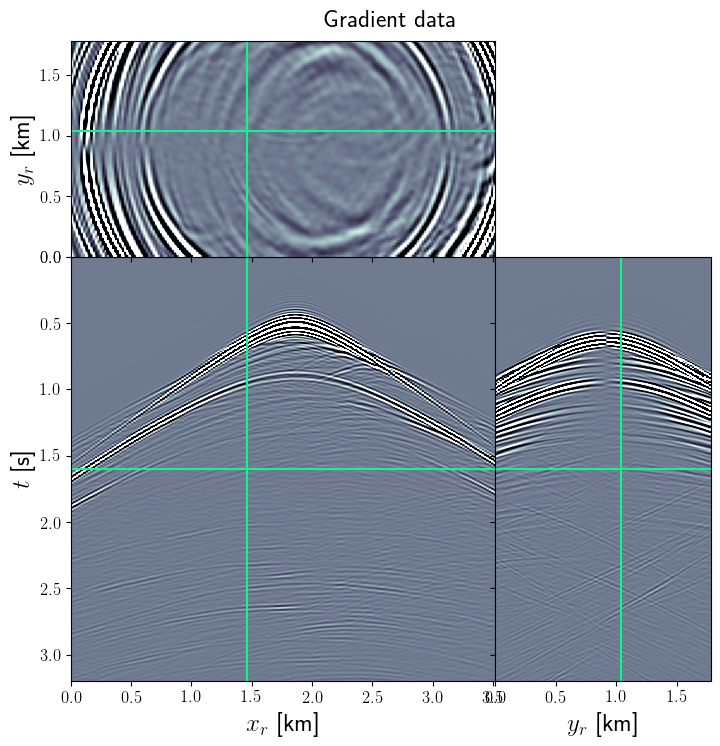

In [3]:
fh = np.load('../../data/ove3d_data.npz')
p = fh['p']
vy = fh['vy']

y = fh['y']
x = fh['x']
t = fh['t']

# Apply wavelet
wav, _, wav_c = ricker(t[:101], fwav)

p = np.apply_along_axis(convolve, 2, p, wav, mode="full")
p = p[:, :, wav_c:][:, :, :nt]
vy = np.apply_along_axis(convolve, 2, vy, wav, mode="full")
vy = vy[:, :, wav_c:][:, :, :nt]

# Spatial derivatives from pressure data
#p1, _, _, _, Fop, D1op, D2op, D, D1, _, kys, kxs, f = \
#    gradient_data3d(p, nfft_y, nfft_x, nfft_t, dy, dx, dt, dtype=np.complex128)

# Spatial derivatives from particle velocity data
Dt = FirstDerivative((ny, nx, nt), axis=2, sampling=dt, order=5, edge=True)
p1 = - (Dt * vy) * density

explode_volume(p.transpose(2,1,0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-1e-4, 1e-4), figsize=(8, 8), 
               title='Data');

explode_volume(p1.transpose(2,1,0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-1e-6, 1e-6), figsize=(8, 8), 
               title='Gradient data');

np.savez(f'../../data/ove3d_data_forsub{nsub}.npz', data=p, grad1=p1, y=y, x=x, t=t, ys=ys, xs=xs)

In [4]:
# Subsample
psub = p[::nsub] 
p1sub = p1[::nsub] 

np.savez(f'../../data/ove3d_data_sub{nsub}.npz', data=psub, grad1=p1sub, yorig=y, y=y[::nsub], 
         x=x, t=t, ys=ys, xs=xs)